# Crop Landcover Exploration

This notebook contains some exploratory data analysis for this problem. Our goal is to build and understand a model for predicting crop types for fields in South Africa, based on satellite imagery from Sentinel 2 Level 2-A.

Our labels come from the [South Africa Crop Type Competition](https://registry.mlhub.earth/10.34911/rdnt.j0co8q/). They're a collection of scenes, with integers indicating the crop type at each pixel in the scene.

Our training data comes from Microsoft's Planetary Computer. The [Sentinel 2 Level 2-A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) page describes what all is avaiable.

## Data Access

We'll use STAC to easily find and load the data we care about. We'll interact with two STAC catalogs

1. A catalog for the labels, hosted in a Blob Storage container
2. The Planetary Computer's STAC API, which catalogs all of Sentinel 2 Level 2-A

The overall workflow will be

1. Load a scene with the label data (a 256x256 array of integers)
2. Search for and load a scene with Sentinel 2 imagery
3. Transform and crop the (very large) Sentinel 2 scene to match the 256x256 label scene

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry

Let's load the collection of training labels, which was based off the collection used in the Radiant Earth competition.

In [2]:
training_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/"
    "train/collection.json"
)
training_catalog

<Collection id=ref_south_africa_crops_competition_v1_train_labels>

That collection has some Items, where each item represents a scene. Each Item has several assets.

In [3]:
label_items = list(training_catalog.get_all_items())
label_items[0].assets

{'documentation': <Asset href=../_common/documentation.pdf>,
 'field_ids': <Asset href=./field_ids.tif>,
 'field_info_train': <Asset href=../../home/jovyan/mlhub/ref_south_africa_crops_competition_v1_train_labels/_common/field_info_train.csv>,
 'labels': <Asset href=./labels.tif>,
 'raster_values': <Asset href=../_common/raster_values.json>}

We're most interested in the `labels` asset, a TIFF with the labels say what each pixel is. We'll grab an "interesting" scene and load the labels into a DataArray:

In [4]:
import rioxarray

label_item = label_items[18]
labels = rioxarray.open_rasterio(
    label_item.assets['labels'].get_absolute_href()
).squeeze()
labels

<xarray.DataArray (y: 256, x: 256)>
array([[6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]], dtype=uint8)
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
  * y            (y) float64 -3.602e+06 -3.602e+06 ... -3.604e+06 -3.604e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

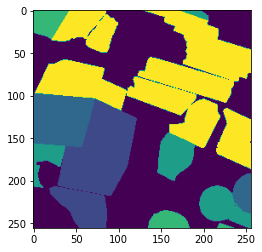

<AxesSubplot:>

In [5]:
import rasterio.plot
import matplotlib.pyplot as plt

rasterio.plot.show(labels)

That item is from a specific date / time.

In [6]:
label_item.datetime

datetime.datetime(2017, 8, 1, 0, 0, tzinfo=tzlocal())

In [7]:
label_item.geometry

{'coordinates': [[[18.46447947403402, -32.552189271279396],
   [18.491720494381838, -32.55273603831489],
   [18.49236223306772, -32.529664371949366],
   [18.465128164182214, -32.529118087556135],
   [18.46447947403402, -32.552189271279396]]],
 'type': 'Polygon'}

We'll search for Sentinel-2 scenes in the Planetary Computer's catalog intersecting with that item from around that datetime

In [8]:
import pystac_client

stac = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)

search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=label_item.geometry,
    datetime="2017-07-01/2017-09-01",
    limit=500,
)

Let's find a scene with few clouds. That information is available under the `EOExtension`.

In [9]:
from pystac.extensions.eo import EOExtension

items = search.get_all_items()
sentinel_item = sorted(
    items,
    key=lambda item: EOExtension.ext(item).cloud_cover
)[0]

And now visualize the Sentinel scene, overlaying the bounding box of the label scene.

In [10]:
from ipyleaflet import Map, TileLayer, GeoJSON

center = shapely.geometry.shape(
    label_item.geometry
).centroid.bounds[:2][::-1]

m = Map(center=center, zoom=12)
layer = TileLayer(
    url=requests.get(sentinel_item.assets['tilejson'].href).json()['tiles'][0],
)
m.add_layer(layer)
m.add_layer(GeoJSON(data=label_item.geometry))
m

Map(center=[-32.54092743431243, 18.47842261141666], controls=(ZoomControl(options=['position', 'zoom_in_text',…

We have a bit of work to align the training labels and the image. First, the epsg doesn't match.

In [11]:
from pystac.extensions.projection import ProjectionExtension
print("  Labels CRS:", labels.rio.crs.to_epsg())
print("Sentinel CRS:", ProjectionExtension.ext(sentinel_item).epsg)

  Labels CRS: 32634
Sentinel CRS: 32734


We'll try to do everything in the coordinates of the labels. As we load the training data into a DataArray, we'll reproject it to the Labels' CRS. We'll also trim it down to just the bit we need, covering the labels scene, to avoid using too much memory.

In [12]:
import planetary_computer
import stackstac

assets = ["B02", "B03", "B04", "B05", "B06", "B07", "B09"]
data = stackstac.stack(
    planetary_computer.sign(sentinel_item).to_dict(),
    assets=assets,
    dtype="float32",
    resolution=10,                  # resample all assets to the highest resolution
    epsg=labels.rio.crs.to_epsg(),  # reproject to the labels CRS
    bounds=labels.rio.bounds(),     # crop to the labels' bounds
).where(lambda x: x > 0).squeeze()

assert data.shape[1:] == labels.shape

data = data.compute()
data

/srv/conda/envs/notebook/lib/python3.8/site-packages/stackstac/accumulate_metadata.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  props_arr = np.squeeze(np.array(props))


<xarray.DataArray 'stackstac-6d55643fc7b6c57be2988027a49ebb2c' (band: 7, y: 256, x: 256)>
array([[[ 589.,  573.,  533., ...,  901.,  377.,  526.],
        [ 437.,  443.,  438., ...,  857.,  643.,  520.],
        [ 379.,  410.,  434., ...,  883.,  773.,  513.],
        ...,
        [ 480.,  517.,  455., ...,  888.,  948.,  730.],
        [ 344.,  504.,  469., ...,  724.,  760.,  620.],
        [ 120.,  277.,  260., ...,  652.,  673.,  608.]],

       [[1176., 1156., 1152., ..., 1246.,  608.,  732.],
        [1110., 1084., 1106., ..., 1266.,  750.,  708.],
        [1021., 1072., 1092., ..., 1158., 1232.,  730.],
        ...,
        [ 589.,  659.,  600., ..., 1234., 1344., 1128.],
        [ 394.,  647.,  618., ..., 1294., 1256., 1042.],
        [ 182.,  325.,  353., ...,  989., 1068.,  961.]],

       [[1004.,  932.,  897., ..., 1632.,  777.,  962.],
        [ 780.,  780.,  750., ..., 1518., 1152.,  933.],
        [ 654.,  747.,  713., ..., 1568., 1404.,  965.],
        ...,
...
        ...,
        [1260., 1260., 1374., ..., 2796., 2827., 2827.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.],
        [ 878.,  878., 1027., ..., 2122., 2369., 2369.]],

       [[4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4484., 4484., 4454., ..., 2034., 1784., 1784.],
        [4765., 4765., 4769., ..., 1880., 1963., 1963.],
        ...,
        [1315., 1315., 1397., ..., 3045., 2952., 2952.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.],
        [ 990.,  990., 1136., ..., 2351., 2548., 2548.]],

       [[4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        [4871., 4871., 4871., ..., 1847., 1847., 1847.],
        ...,
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.],
        [1110., 1110., 1110., ..., 2466., 2466., 2466.]]], dtype=float32)
Coordinates: (12/46)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * band                                     (band) <U3 'B02' 'B03' ... 'B09'
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
  * y                                        (y) float64 -3.602e+06 ... -3.60...
    s2:datatake_id                           <U34 'GS2B_20170728T082559_00204...
    ...                                       ...
    title                                    (band) <U36 'Band 2 - Blue - 10m...
    proj:shape                               (band) object None ... [1830, 1830]
    common_name                              (band) object 'blue' ... None
    center_wavelength                        (band) float64 0.49 0.56 ... 0.945
    full_width_half_max                      (band) float64 0.098 ... 0.026
    epsg                                     int64 32634
Attributes:
    spec:        RasterSpec(epsg=32634, bounds=(261920, -3604480, 264480, -36...
    crs:         epsg:32634
    transform:   | 10.00, 0.00, 261920.00|\n| 0.00,-10.00,-3601920.00|\n| 0.0...
    resolution:  10

Our shapes match (256 x 256 patch), but the labels don't quite.

In [13]:
labels.x

<xarray.DataArray 'x' (x: 256)>
array([261925., 261935., 261945., ..., 264455., 264465., 264475.])
Coordinates:
    band         int64 1
  * x            (x) float64 2.619e+05 2.619e+05 ... 2.645e+05 2.645e+05
    spatial_ref  int64 0

In [14]:
data.x

<xarray.DataArray 'x' (x: 256)>
array([261920., 261930., 261940., ..., 264450., 264460., 264470.])
Coordinates: (12/37)
    time                                     datetime64[ns] 2017-07-28T08:25:...
    id                                       <U38 'S2B_MSIL2A_20170728T082559...
  * x                                        (x) float64 2.619e+05 ... 2.645e+05
    s2:datatake_id                           <U34 'GS2B_20170728T082559_00204...
    s2:high_proba_clouds_percentage          float64 0.01307
    sat:orbit_state                          <U10 'descending'
    ...                                       ...
    s2:saturated_defective_pixel_percentage  float64 0.0
    s2:not_vegetated_percentage              float64 50.9
    s2:mean_solar_azimuth                    float64 32.11
    constellation                            <U10 'Sentinel 2'
    proj:bbox                                object {6500020.0, 6390220.0, 19...
    epsg                                     int64 32634

They're off by half a pixel (5 units in coordinate space). This probably just comes from one dataset labeling the center of the pixel and the other labeling the top-left corner. It'd be good to verify that. In the meantime, let's just update the labels on `data`

In [15]:
data2 = (
    data.assign_coords(
        y=lambda ds: (ds.y - 5).round(),   # fix half-pixel label issue
        x=lambda ds: (ds.x + 5).round(),
    )
)

Now we should be all set.

In [16]:
assert (data2.x.data == labels.x.data).all()
assert (data2.y.data == labels.y.data).all()

And we can spot-check out transformation visually. Let's plot the Red band.

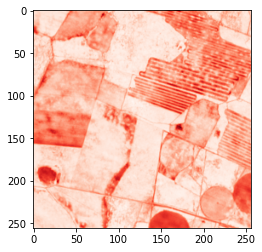

In [17]:
rasterio.plot.show(data2.sel(band="B04"), cmap="Reds");

Which looks pretty close to what we want.

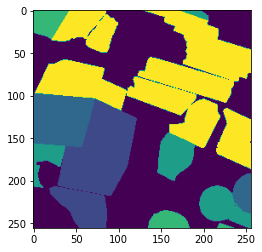

In [18]:
rasterio.plot.show(labels);

## Train a Baseline Model

We've come this far, we might as well do some machine learnign! We'll use a scikit-learn K-Nearest Neighbors classifier to establish a baseline model for this dataset.

As usual with scikit-learn, the estimator expects an intput array of `(n_samples, n_features)`. In this case a "sample" will be a single pixel, and the feature will be all the bands. We'll get to that shape by stacking all the the pixels into one long array.

In [19]:
X = data2.stack(pixel=("y", "x")).T
X.shape

(65536, 7)

We'll also reshape the labels to be a 1-D array `(n_features,)`

In [20]:
y = labels.stack(pixel=("y", "x"))
y.shape

(65536,)

In [21]:
assert X.indexes['pixel'].equals(y.indexes['pixel'])

Let's split our data (this single image) into training and test sets.

In [22]:
import sklearn.neighbors
import sklearn.model_selection

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

And fit the model.

In [23]:
nn = sklearn.neighbors.KNeighborsClassifier()
%time nn.fit(X_train, y_train)

CPU times: user 43.7 ms, sys: 3.96 ms, total: 47.7 ms
Wall time: 47 ms


KNeighborsClassifier()

And check it on the train and test datasets.

In [24]:
%time nn.score(X_train, y_train)

CPU times: user 1.51 s, sys: 0 ns, total: 1.51 s
Wall time: 1.51 s


0.8942057291666666

In [25]:
%time nn.score(X_test, y_test)

CPU times: user 522 ms, sys: 0 ns, total: 522 ms
Wall time: 521 ms


0.84075927734375

We're overfitting a bit (89% on our training dataset, 84% on our test), but not too bad. Let's visualize the predictions.

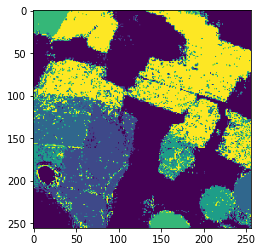

In [26]:
yhat = nn.predict(X)

rasterio.plot.show(
    yhat.reshape(labels.shape)
);

Not *awful*, but certainly room for improvement. A few things to note:

1. We haven't done any fancy preprocessing (e.g. mosaicing scenes to remove clouds) that could improve this model.
2. We haven't done any fancy hyper-parameter tuning that could improve this model.
3. We aren't using the spatial "context" of each pixel at all, which leads to the splotchiness in our predictions. If a pixel is surrounded on all sides by Wheat pixels, then it's probably a Wheat pixel. But our current model has no idea about the neighboring pixels.
4. There's a lot of variation across the scenes in the label data. Our model hasn't seen any of those, so likely won't generalize well to them. We'd need to train on more data.